# ε-greedy and greedy comparisons in the 5 armed bandit problem

This notebooks show a comparison of the ε-greedy and greedy algorithm to solve the 
5 armed bandit problem.

## Installation

Prepare a virtual environment with the Jupyter notebook dependencies:

```bash
python3.13 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

## Usage

Open the Jupyter notebook, using the virtual environment as the kernel.
Run all the notebooks cells to get the final plot showing the experiment results

### Import dependencies

The random, numpy, and matplotlib packages are used in the algorithm:

In [237]:
import random
import numpy as np
import matplotlib.pyplot as plt

### Define experiment paramenters

The experiment parameters are preconfigured with the required arguments.

In [238]:
# Experiment Parameters
k = 5
runs = 200
steps = 100
epsilon = 0.4

### Define an ε-greedy bandit implementation

The implementatin takes as parameters a `bandit` function that produced rewards,
a `k` parameter with the number of available actions, an `epsilon` parameter to
control exploration vs explotation rate, and a `steps` parameter that define the
number of time steps to run the algorithm.

The algorithm select random actions (explore) with `epsilon` probability, and pick
the best available action (exploits) with `1 - epsilon` probability. Setting `epsilon=0`
makes it work like a greedy algorithm.

Once the action is selected, the `bandit` function is executed to get a reward, and
updates to the estimated values for each arm `Q` and their respective count `N`, using
an incremental update method.

To plot the evolution of the algorithm over time, a `history` is kept with all the
values of the rewards over `steps`.

In [239]:

# Define an epsilon greedy bandit
def epsilon_greedy_bandit(bandit, k, epsilon=epsilon, steps=steps):

    Q = [0.0] * k  # estimated values
    N = [0] * k  # action counts
    history = [] # history

    for _ in range(steps):
        
        # Choose action
        if random.random() < epsilon:

            # explore
            A = random.randrange(k)
        else:
            # exploit
            max_Q = max(Q)
            
            # break ties randomly among best actions
            best_actions = [i for i, q in enumerate(Q) if q == max_Q]
            A = random.choice(best_actions)

        # Take action and observe reward
        R = bandit(A)

        # Incremental update of N(A) and Q(A)
        N[A] += 1
        Q[A] += (R - Q[A]) / N[A]

        # Save the history
        history.append(R)

    return Q, N, history


### Experiment execution

First, we define `true_means` as the action values of the `k` actions.
The values are taken from a normal distribution, with mean 0 and standard
deviation 1, as used in the Section 2.3 of our book (to reproduce a similar)
experiment.

Then, the `bandit` function is defined, returning a random reward based on the
true mean for the selected action.

The experiment is then run over `runs` iterations, and the average rewards
accross all iterations is calculated.

Three experiments are run in parallel:

1. The ε-greedy version with ε = 0.4
2. The greedy version with ε = 0
3. A control ε-greedy version with ε = 0.1

In [240]:

# Set true means of the bandits
true_means = np.random.normal(0, 1, k)

# Define a bandit function
def bandit(a):

    # stochastic reward based on normal distribution around true mean
    return np.random.normal(true_means[a], 1)

# Initialize results for epsilon greedy implementation
e_greedy = {
    "Q": np.zeros((runs, k)),
    "N": np.zeros((runs, k)),
    "H": np.zeros((runs, steps))
}

# Initialize results for a control epsilon greedy implementation
control_epsilon_greedy = {
    "Q": np.zeros((runs, k)),
    "N": np.zeros((runs, k)),
    "H": np.zeros((runs, steps))
}

# Initialize results for greedy implementation
greedy = {
    "Q": np.zeros((runs, k)),
    "N": np.zeros((runs, k)),
    "H": np.zeros((runs, steps))
}

# Run experiments
for i in range(runs):

    # Run epsilon greedy bandit
    e_greedy["Q"][i], e_greedy["N"][i], e_greedy["H"][i] = epsilon_greedy_bandit(
        bandit, k=k, epsilon=epsilon, steps=steps
    )

    # Run greedy bandit
    greedy["Q"][i], greedy["N"][i], greedy["H"][i] = epsilon_greedy_bandit(
        bandit, k=k, epsilon=0, steps=steps
    )

    # Run the control epsilon greedy bandit
    control_epsilon_greedy["Q"][i], control_epsilon_greedy["N"][i], control_epsilon_greedy["H"][i] = epsilon_greedy_bandit(
        bandit, k=k, epsilon=0.1, steps=steps
    )

# Compute average rewards over all runs
Hegavg = np.mean(e_greedy["H"], axis=0)
Hgavg = np.mean(greedy["H"], axis=0)
Hcqgavg = np.mean(control_epsilon_greedy["H"], axis=0)

### Result Plots

Finally, we plot the average historical rewards for the greedy and ε-greedy versions with ε = 0.4.

As we can see, the ε-greedy version with ε = 0.4 (magenta) is not better than the greedy version (green)
on maximizing rewards. Our hypotesis is that the exploration rate is too high and impacts negatively in
the performance of the algorithm.

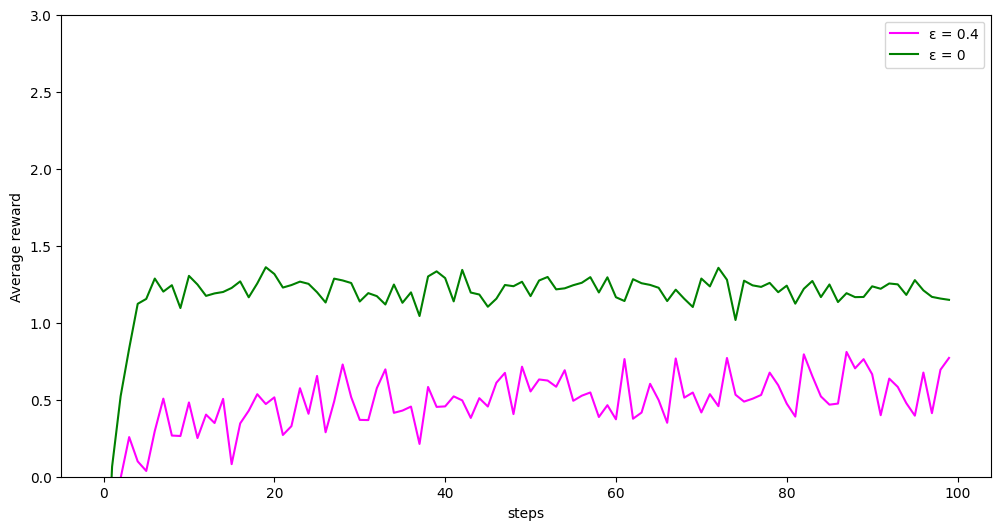

In [241]:

# Plot average rewards
plt.figure(figsize=(12,6))
plt.plot(Hegavg, label=f"ε = {epsilon}", color="magenta")
plt.plot(Hgavg, label="ε = 0", color="green")
plt.ylim(0, 3)
plt.xlabel("steps")
plt.ylabel("Average reward")
plt.legend()
plt.show()

### Control Plot

Now, we plot the average historical rewards for the greedy and ε-greedy versions with ε = 0.1.

As we can see, the ε-greedy version with ε = 0.1 (blue) is slightly better than the greedy version (green)
on maximizing rewards. This mimics the results on the Section 2.3 of our books, and serve as a
control mechanism to check that the implementation is correct.

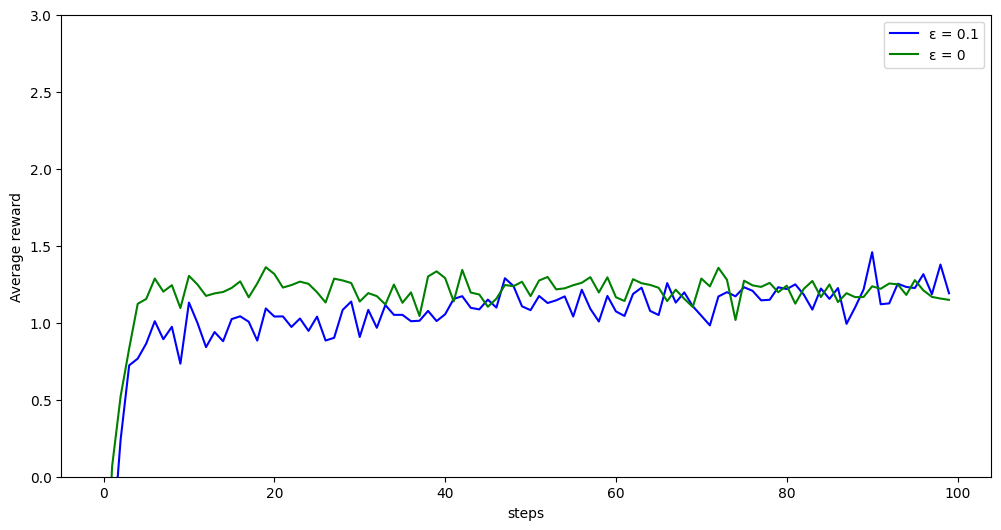

In [242]:
# Plot average rewards
plt.figure(figsize=(12,6))
plt.plot(Hcqgavg, label=f"ε = 0.1", color="blue")
plt.plot(Hgavg, label="ε = 0", color="green")
plt.ylim(0, 3)
plt.xlabel("steps")
plt.ylabel("Average reward")
plt.legend()
plt.show()